In [2]:
import os
import shutil
import random

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import uuid

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# download train data
!rm -rf lfw lfw.*
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xf lfw.tgz

# move
data_dir = "data"
neg_path = f"{data_dir}/negative"
pos_path = f"{data_dir}/positive"
anc_path = f"{data_dir}/anchor"

shutil.rmtree(data_dir, ignore_errors=True)
os.mkdir(data_dir)
os.mkdir(neg_path)
os.mkdir(pos_path)
os.mkdir(anc_path)

# negative
for directory in os.listdir('lfw')[:1300]:
    if directory != "George_W_Bush":
      for file in os.listdir(os.path.join('lfw', directory)):
          shutil.copyfile(f"lfw/{directory}/{file}", f"{neg_path}/{file}")

print(len(os.listdir(neg_path)))


# postive and anchor
files = list(os.listdir("lfw/George_W_Bush"))
random.shuffle(files)

anchor = files[:int(len(files)*.5)]
positive = files[int(len(files)*.5):]

def copy(file, dst):
  shutil.copyfile("lfw/George_W_Bush/"+file, dst+file)

[copy(src, "data/anchor/") for src in anchor]
[copy(src, "data/positive/") for src in positive]

print(len(anchor), len(positive))

3041
265 265


In [ ]:
!rm -f haarcascade_frontalface_default.xml haarcascade_eye.xml
!wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml
!wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_eye.xml

--2022-06-21 17:49:10--  https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml [following]
--2022-06-21 17:49:10--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   



In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

def get_cropped(image_path, check_eye=False):
    img = cv2.imread(image_path)
    # print(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 5, 5)
    for (x,y,w,h) in faces:
        roi_color = img[y:y+h, x:x+w]

        if check_eye:
          roi_gray = gray
          eyes = eye_cascade.detectMultiScale(roi_gray)
          if len(eyes) >= 2:
              return roi_color
        else:
          return roi_color

print("before", ([(len(files), dir) for dir, _, files in os.walk("data")]))

shutil.rmtree("final_data", ignore_errors=True)
os.makedirs("final_data/negative")
os.makedirs("final_data/positive")
os.makedirs("final_data/anchor")

for dir in os.listdir("data"):
  for file in os.listdir(f"data/{dir}"):
      image = get_cropped(f"data/{dir}/{file}", True)
      if image is not None:
        cv2.imwrite(os.path.join(f"final_data/{dir}", file), image)

shutil.rmtree("data")
shutil.move("final_data", "data")

print("after", ([(len(files), dir) for dir, _, files in os.walk("data")]))

before [(0, 'data'), (3041, 'data/negative'), (265, 'data/anchor'), (265, 'data/positive')]
after []


In [ ]:
print("after", ([(len(files), dir) for dir, _, files in os.walk("data")]))

after [(0, 'data'), (2136, 'data/negative'), (166, 'data/anchor'), (171, 'data/positive')]


In [ ]:
# augment data
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    return data

def augment(PATH):
  for file_name in os.listdir(os.path.join(PATH)):
      img_path = os.path.join(PATH, file_name)
      img = cv2.imread(img_path)
      augmented_images = data_aug(img) 
      
      for image in augmented_images:
          cv2.imwrite(os.path.join(PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

augment("data/anchor")
augment("data/positive")

In [ ]:
print("after", ([(len(files), dir) for dir, _, files in os.walk("data")]))

after [(0, 'data'), (2136, 'data/negative'), (1660, 'data/anchor'), (1710, 'data/positive')]


In [ ]:
def get_file_tag(path):
  return path, tf.strings.split(path, os.path.sep)[-1]

def read_file(file_path, resize_shape=None, normalize=False):
  img = tf.io.read_file(file_path) # load the raw data from the file as a string
  img = tf.image.decode_jpeg(img)

  if resize_shape is not None:
    img = tf.image.resize(img, resize_shape)
  if normalize:
    img = img / 255.0
  
  return img

def normalize(img):
  return img / 255

def get_data(pattern, with_tag=False, resize=None, normalize=False):
  data = tf.data.Dataset.list_files(file_pattern=pattern)

  if with_tag:
    data = data.map(lambda path: (read_file(path, resize, normalize), get_file_tag(path)))
  else:
    data = data.map(lambda path: read_file(path, resize, normalize))
  return data

In [ ]:
data_dir = "data"
# shape = (224, 224)
shape = (100, 100)

# load data
anchor = get_data(data_dir+"/anchor/*.jpg", resize=shape, normalize=True)
positive = get_data(data_dir+"/positive/*.jpg", resize=shape, normalize=True)
negative = get_data(data_dir+"/negative/*.jpg", resize=shape, normalize=True)

# merge data
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

# performance
data = data.shuffle(buffer_size=10000)
data = data.prefetch(tf.data.AUTOTUNE)
data = data.cache().batch(10)

# train test splitting
train_size = round(len(data)*0.7)

train_data = data.take(train_size)
test_data = data.skip(train_size)

print(len(train_data), len(test_data))

232 100


In [ ]:
# d = get_data("*.jpg", resize=(100, 100), normalize=True)

# # d.as_numpy_iterator().next()*255
# plt.imshow((d.as_numpy_iterator().next()*255).astype("int"))

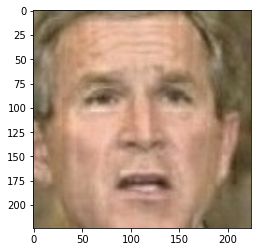

In [ ]:
r = train_data.as_numpy_iterator().next()
# len(r[0])
plt.imshow(r[1][2])

In [3]:
# get model ready
from keras.metrics import Precision, Recall
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, GlobalAveragePooling2D

# input_shape = (224, 224, 3)
input_shape = (100, 100, 3)

# embeding
def make_embedding(): 
    inp = Input(shape=input_shape, name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

# Transfer Learning: Use resnet50 pretrained model
# def make_embedding(): 
#     model = tf.keras.applications.ResNet50(include_top=True, input_shape=(224, 224, 3))
#     for layer in model.layers[:-1]:
#       layer.trainable = False
#     model.layers[-1].trainable = True
    
#     # x = Flatten()(model.output)
#     # x = Dense(100, activation='sigmoid')(x)
#     # predictions = Dense(4096, activation='sigmoid')(x)

#     # full_model = Model(inputs=model.input, outputs=predictions, name="embedding")
#     return model
#     # return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()

# Siamese L1 Distance class
class L1Dist(Layer):      
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=input_shape)
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=input_shape)
    
    # Combine siamese distance components
    siamese_layer = L1Dist(name="distance")
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    # print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
 
            progbar.update(idx+1)
        print("Loss - {}, Recall - {}, Precision - {}".format(loss.numpy(), r.result().numpy(), p.result().numpy()))
        
        # Save checkpoints
        # if epoch % 10 == 0: 
        #     checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

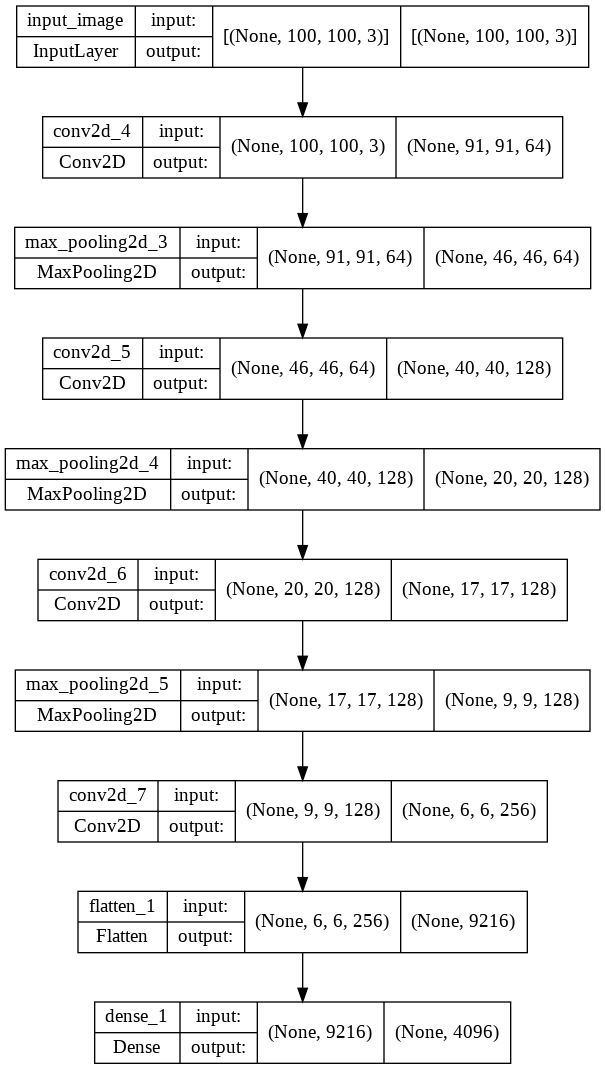

In [4]:
tf.keras.utils.plot_model(embedding, show_shapes=True)

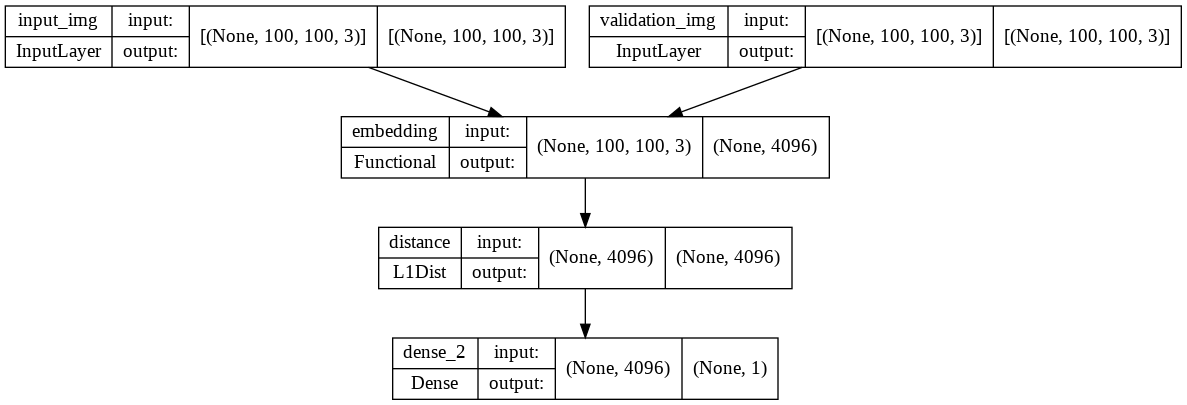

In [5]:
tf.keras.utils.plot_model(siamese_model, show_shapes=True)

In [ ]:
train(train_data, 10)


 Epoch 1/10
232/232 [==============================] - 48s 187ms/step
Loss - 0.17372526228427887, Recall - 0.9627329111099243, Precision - 0.9593280553817749

 Epoch 2/10
232/232 [==============================] - 41s 168ms/step
Loss - 0.301739364862442, Recall - 0.9587274193763733, Precision - 0.9457167387008667

 Epoch 3/10
232/232 [==============================] - 41s 167ms/step
Loss - 0.3334372043609619, Recall - 0.9750645160675049, Precision - 0.9684031009674072

 Epoch 4/10
232/232 [==============================] - 42s 171ms/step
Loss - 0.14240938425064087, Recall - 0.9573378562927246, Precision - 0.9500423073768616

 Epoch 5/10
232/232 [==============================] - 41s 167ms/step
Loss - 0.1254412829875946, Recall - 0.9713789820671082, Precision - 0.9548166990280151

 Epoch 6/10
232/232 [==============================] - 51s 210ms/step
Loss - 0.08051282912492752, Recall - 0.9674582481384277, Precision - 0.960698664188385

 Epoch 7/10
232/232 [=============================

In [ ]:
import numpy as np

def test():
  total = 0
  true = 0

  for batch in test_data:
    y_true = batch[2]
    y_pred = siamese_model.predict(batch[:2])
    y_pred = np.squeeze(y_pred)
    y_pred[y_pred >= .5] = 1
    y_pred[y_pred < .5] = 0
    total += len(y_true)
    true += (y_true.numpy() == y_pred).sum()
  print(f"{true}/{total} => {true/total}")

test()

956/1000 => 0.956


In [ ]:
# Save weights
siamese_model.save('siamesemodel_cropped_40epoch.h5')